# Solution: Raster data needs reprojection

## 📂 Open the source data (in EPSG:3413)

In [1]:
%matplotlib widget
# Set up matplotlib interactive "magic"

In [2]:
import rioxarray
import matplotlib.pyplot as plt
import numpy as np
from rasterio.enums import Resampling

epsg_3413 = rioxarray.open_rasterio('../dem_with_altered_metadata.tif')
epsg_3413

<xarray.DataArray (band: 1, y: 561, x: 301)>
[168861 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -8e+05 -7.95e+05 -7.9e+05 ... 6.95e+05 7e+05
  * y            (y) float64 -6e+05 -6.05e+05 -6.1e+05 ... -3.395e+06 -3.4e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:        Area
    TIFFTAG_XRESOLUTION:  1
    TIFFTAG_YRESOLUTION:  1
    scale_factor:         1.0
    add_offset:           0.0
    long_name:            band_data

### Plot the source data

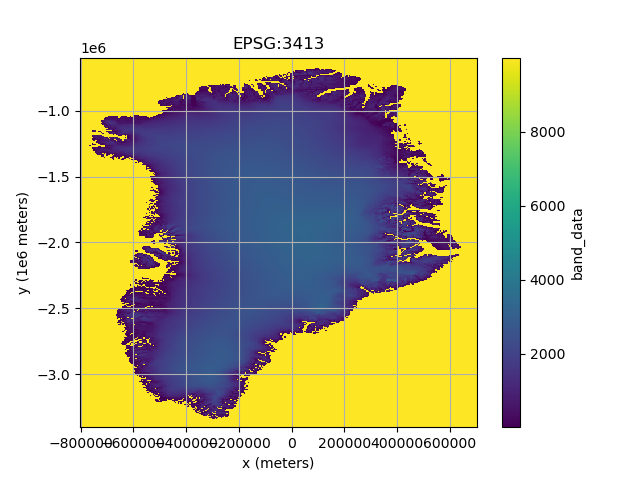

In [3]:
plt.figure()
plot = epsg_3413[0].plot.imshow()

plot.axes.set_title('EPSG:3413')
plot.axes.set_xlabel('x (meters)')
plot.axes.set_ylabel('y (1e6 meters)')
plot.axes.grid()
plt.show()

## 🌐 Reproject the dataset

In [4]:
epsg_4326 = epsg_3413.rio.reproject(
    "EPSG:4326",
    resampling=Resampling.bilinear,
)

### Plot it again!

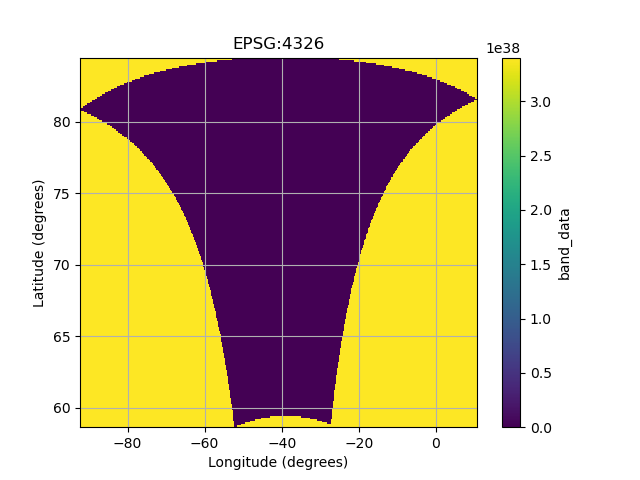

In [5]:
plt.figure()

plot = epsg_4326[0].plot.imshow()
plot.axes.grid()
plot.axes.set_title('EPSG:4326')
plot.axes.set_xlabel('Longitude (degrees)')
plot.axes.set_ylabel('Latitude (degrees)')
plt.show()

## ⁉️ What's going on?

This result is clearly wrong. What is this shape? Why is the data "gone", and what does the yellow color represent?

We're seeing the shape of the extent of the original data in purple. The original rectangular shape had to be warped to align to the geographic projection grid. Outside that area, the yellow color is a very large number being used as a NoData value.

This is because this dataset does not have a NoData value correctly set to 9999.

In [6]:
print(f"Top-left corner value: {epsg_4326[0][0][0].data}")
print(f"NoData value: {epsg_4326[0].rio.nodata}")
print(f"Xarray FillValue: {epsg_4326[0]._FillValue}")

Top-left corner value: 3.4028234663852886e+38
NoData value: 3.4028234663852886e+38
Xarray FillValue: 3.402823466e+38


/home/mfisher/.miniconda3/envs/geotools/lib/python3.11/site-packages/rioxarray/raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


## 🥸 Masking the NoData values

We expect the NoData value to be 9999, so let's mask it out.

In [7]:
epsg_4326_da = epsg_4326[0]
epsg_4326_da = epsg_4326_da.where(epsg_4326_da != 9999)

### Plot!

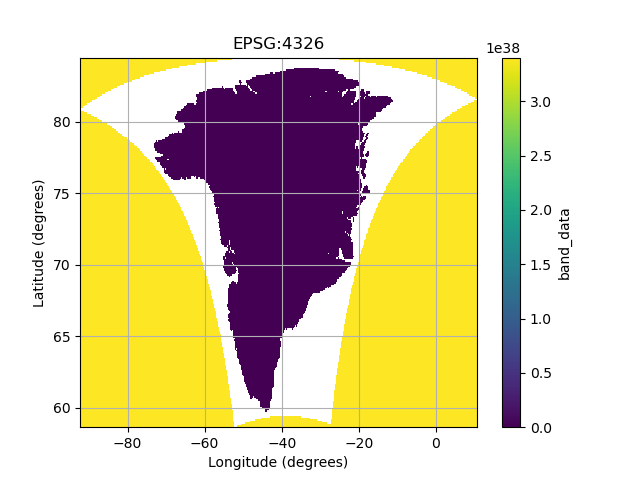

In [8]:
plt.figure()
plot = epsg_4326_da.plot.imshow()
plot.axes.grid()
plot.axes.set_title('EPSG:4326')
plot.axes.set_xlabel('Longitude (degrees)')
plot.axes.set_ylabel('Latitude (degrees)')
plt.show()

## ⁉️ What's going on?

We've successfully masked out the NoData values, but that only applied to the values in the original dataset. This is showing two NoData values: `9999` from the original dataset, and the maximum `Float32` value for pixels outside of the original dataset.

We can mask those out, too:

In [9]:
epsg_4326_da = epsg_4326_da.where(epsg_4326_da <= 9999)

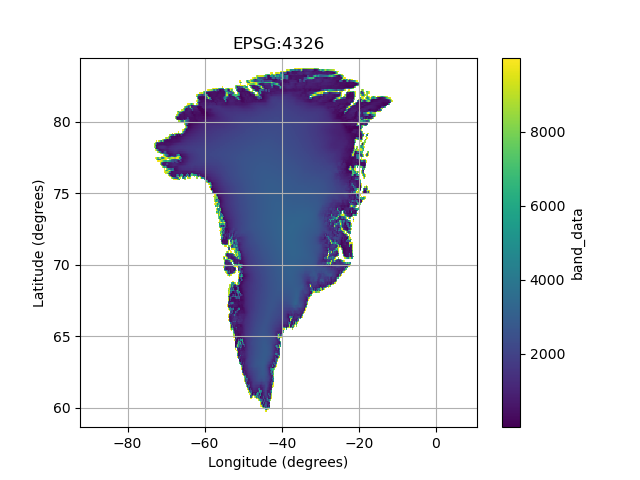

In [10]:
plt.figure()
plot = epsg_4326_da.plot.imshow()
plot.axes.grid()
plot.axes.set_title('EPSG:4326')
plot.axes.set_xlabel('Longitude (degrees)')
plot.axes.set_ylabel('Latitude (degrees)')
plt.show()

This has uncovered an even larger issue! The edge pixels were interpolated during the original reprojection because the NoData value was not appropriately set. Looks like we need to go back even further to fix this, rather than masking the problem.

## 🌐 Reproject the dataset; 2nd try

First, correctly set the NoData value on the source. _Then_ reproject.

In [42]:
epsg_3413_fixed = epsg_3413.rio.write_nodata(9999, encoded=True)
epsg_3413_fixed = epsg_3413_fixed.where(epsg_3413_fixed != epsg_3413_fixed.rio.encoded_nodata)
epsg_4326_fixed = epsg_3413_fixed.rio.reproject(
    "EPSG:4326",
    resampling=Resampling.bilinear,
)

<xarray.DataArray ()>
array(nan, dtype=float32)
Coordinates:
    band         int64 1
    x            float64 -8e+05
    y            float64 -6e+05
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:        Area
    TIFFTAG_XRESOLUTION:  1
    TIFFTAG_YRESOLUTION:  1
    scale_factor:         1.0
    add_offset:           0.0
    long_name:            band_data

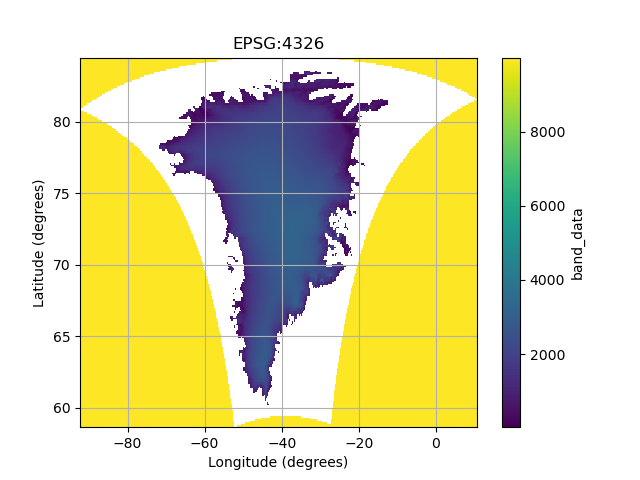

In [41]:
plt.figure()
plot = epsg_4326_fixed[0].plot.imshow()
plot.axes.grid()
plot.axes.set_title('EPSG:4326')
plot.axes.set_xlabel('Longitude (degrees)')
plot.axes.set_ylabel('Latitude (degrees)')
plt.show()